# $\text{Arrow Debreu European Option Pricing}$

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import nnls

In [4]:
ticker = 'AAPL'
ticker_data = yf.Ticker(ticker)
expiry = ticker_data.options[4]
print('Using Expiry:', expiry)
chain = ticker_data.option_chain(expiry)
calls = chain.calls #the pricing will be based just on calls 

Using Expiry: 2025-09-05


In [5]:
spot = ticker_data.history(period='1d')['Close'].iloc[-1]
possible_states = np.linspace(spot - 50, spot + 50, 11, dtype=int)
print('Using Spot:', spot)
print(f'Will be pricing options for the following spot prices: {possible_states} expiring on {expiry}')

Using Spot: 213.25
Will be pricing options for the following spot prices: [163 173 183 193 203 213 223 233 243 253 263] expiring on 2025-09-05


In [6]:
available_strikes = sorted(calls["strike"])
print('Available Strikes:\n', available_strikes)

Available Strikes:
 [140.0, 150.0, 155.0, 165.0, 175.0, 180.0, 185.0, 190.0, 195.0, 200.0, 205.0, 210.0, 215.0, 220.0, 225.0, 230.0, 235.0, 240.0, 245.0, 250.0, 255.0, 260.0, 265.0, 270.0, 275.0, 280.0, 285.0, 300.0]


In [7]:
atm_index = min(range(len(available_strikes)), key=lambda i: abs(available_strikes[i] - spot))
print('Index of the closest strike price to the spot price:', atm_index)

Index of the closest strike price to the spot price: 12


In [8]:
lower_bound = max(atm_index - 5, 0)
upper_bound = min(atm_index + 6, len(available_strikes))
print(f'Lower index bound: {lower_bound}\n', f'Upper undex bound: {upper_bound}')

Lower index bound: 7
 Upper undex bound: 18


In [9]:
chosen_strikes = available_strikes[lower_bound:upper_bound]
chosen_strikes = np.array(chosen_strikes)
print(f'Selected {len(chosen_strikes)} strikes around ATM:', '\n', sorted(chosen_strikes))

Selected 11 strikes around ATM: 
 [190.0, 195.0, 200.0, 205.0, 210.0, 215.0, 220.0, 225.0, 230.0, 235.0, 240.0]


In [10]:
chosen_calls = calls[calls['strike'].isin(chosen_strikes)].copy().reset_index(drop=True)
chosen_calls = chosen_calls[['strike', 'bid', 'ask']]
chosen_calls.head()

,strike,bid,ask
0,190.0,0.0,0.0
1,195.0,0.0,0.0
2,200.0,0.0,0.0
3,205.0,0.0,0.0
4,210.0,0.0,0.0


In [11]:
chosen_calls['price_vector'] = (chosen_calls['bid']+chosen_calls['ask'])/2
chosen_calls = chosen_calls[['strike', 'price_vector']]
chosen_calls.head()

,strike,price_vector
0,190.0,0.0
1,195.0,0.0
2,200.0,0.0
3,205.0,0.0
4,210.0,0.0


In [12]:
strikes = chosen_calls["strike"].values
price_vector = chosen_calls["price_vector"].values
print(strikes)
print(price_vector)

[190. 195. 200. 205. 210. 215. 220. 225. 230. 235. 240.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [13]:
terminal_prices = strikes.copy()
call_payoff_matrix = np.maximum(possible_states - chosen_strikes[:, None], 0)
put_payoff_matrix  = np.maximum(chosen_strikes[:, None] - possible_states, 0)
print(f'Call payoff matrix piece:\n {call_payoff_matrix[:5,:5]}\n Put payoff matrix piece\n {put_payoff_matrix[:5,:5]}\n Payoff matrices shape: {call_payoff_matrix.shape}')


Call payoff matrix piece:
 [[ 0.  0.  0.  3. 13.]
 [ 0.  0.  0.  0.  8.]
 [ 0.  0.  0.  0.  3.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
 Put payoff matrix piece
 [[27. 17.  7.  0.  0.]
 [32. 22. 12.  2.  0.]
 [37. 27. 17.  7.  0.]
 [42. 32. 22. 12.  2.]
 [47. 37. 27. 17.  7.]]
 Payoff matrices shape: (11, 11)


In [14]:
#state_prices, _, _, _ = np.linalg.lstsq(call_payoff_matrix, price_vector, rcond=None)
state_prices, _ = nnls(call_payoff_matrix, price_vector)
normalized_state_prices = state_prices/np.sum(state_prices)

r=0.0416
T=30/365
probabilities = state_prices * np.e**(r*T)

/var/folders/1w/t9ll1lr96djf5mqhmd8k_1p80000gn/T/ipykernel_11491/169700691.py:3: RuntimeWarning: invalid value encountered in divide
  normalized_state_prices = state_prices/np.sum(state_prices)


In [15]:
#'p.s. "np.linalg.lstsq" was resulting in some values being negative so I had to use "scipy.optimize.nnls" i.e non-negative least squares.')

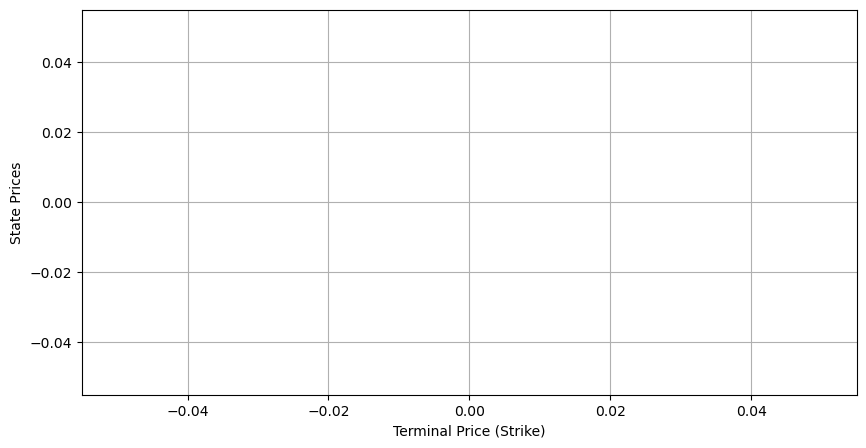

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(terminal_prices, normalized_state_prices, marker='o')
plt.xlabel('Terminal Price (Strike)')
plt.ylabel('State Prices')
plt.grid(True)
plt.show()

In [17]:
call_prices = call_payoff_matrix @ normalized_state_prices
put_prices = put_payoff_matrix @ normalized_state_prices

call_prices = pd.DataFrame({
    'Strike': chosen_strikes,
    '$Call': call_prices,
    '$Put': put_prices
})
call_prices


,Strike,$Call,$Put
0,190.0,NaN,NaN
1,195.0,NaN,NaN
2,200.0,NaN,NaN
3,205.0,NaN,NaN
4,210.0,NaN,NaN
5,215.0,NaN,NaN
6,220.0,NaN,NaN
7,225.0,NaN,NaN
8,230.0,NaN,NaN
9,235.0,NaN,NaN


In [36]:
print(state_prices)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
